# LightGCN

In [1]:
import torch

## Data

In [2]:
from gcn.data import read_data_ml100k, split_data_ml100k, load_data_ml100k
ratings_df, num_users, num_items = read_data_ml100k("./data/ml-latest-small")
train_data, test_data = split_data_ml100k(ratings_df, num_users, 'seq-aware', test_ratio=0.1)
users_train, items_train, ratings_train, train_candidates = load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit"
) # train_candidates is a dict of {user: [items]}
users_test, items_test, ratings_test, test_candidates = load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit"
) # test_candidates is a dict of {user: [items]}

In [3]:
len(train_data)

100226

In [4]:
len(test_data)

610

In [5]:
user_dim = torch.LongTensor(users_train)
item_dim = torch.LongTensor(items_train)
first_sub = torch.stack([user_dim, item_dim + num_users])
second_sub = torch.stack([item_dim + num_users, user_dim])
index = torch.cat([first_sub, second_sub], dim=1)
data = torch.ones(index.size(-1)).int()
Graph = torch.sparse.IntTensor(
    index, data,
    torch.Size([num_users+num_items, num_users+num_items])
)
dense = Graph.to_dense()
"""
A =
    |I,   R|
    |R^T, I|
"""
D = torch.sum(dense, dim=1).float()
D[D==0.] = 1. # avoid dividing by zero
D_sqrt = torch.sqrt(D).unsqueeze(dim=0)
dense = dense/D_sqrt
dense = dense/D_sqrt.t()
"""
A = D^{-1/2} @ A @ D^{-1/2}
"""
index = dense.nonzero()
data  = dense[dense >= 1e-9]
assert len(index) == len(data)
Graph = torch.sparse.FloatTensor(
    index.t(), data,
    torch.Size([num_users+num_items, num_users+num_items])
) # Graph is a symmetric matrix now

/tmp/ipykernel_41398/2863010693.py:7: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  Graph = torch.sparse.IntTensor(


In [6]:
import random
class PRDataset(torch.utils.data.Dataset):
    def __init__(self, users, items, candidates, num_items):
        self.users = users
        self.items = items
        self.cand = candidates
        self.all = set([i for i in range(num_items)])

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        neg_items = list(self.all - set(self.cand[int(self.users[idx])]))
        indices = random.randint(0, len(neg_items) - 1)
        return self.users[idx], self.items[idx], neg_items[indices]

In [7]:
batch_size = 1024
trainset = PRDataset(users_train, items_train, train_candidates, num_items)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [8]:
len(train_loader)

98

## Model Config

In [9]:
from gcn.models import LightGCN
from gcn.loss import BPRLoss
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 10
model = LightGCN(num_users, num_items, n_factors, Graph.to(device))
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss_fn = BPRLoss()

## Train

In [10]:
%matplotlib inline

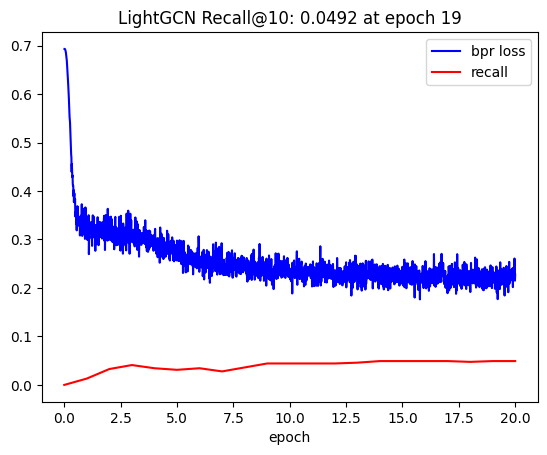

LightGCN Recall@10: 0.0492 at epoch 19


In [11]:
from gcn.train import evaluate_ranking
from gcn.visualize import Animator
ani = Animator()
num_epochs = 20
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        input_data = []
        for v in values:
            input_data.append(v.to(device))

        p_pos = model(input_data[0], input_data[1])
        p_neg = model(input_data[0], input_data[-1])
        loss = loss_fn(p_pos, p_neg)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        epoch_list.append(epoch+1)


    scheduler.step()

    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='bpr loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'LightGCN Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'LightGCN Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}')

ani.close()

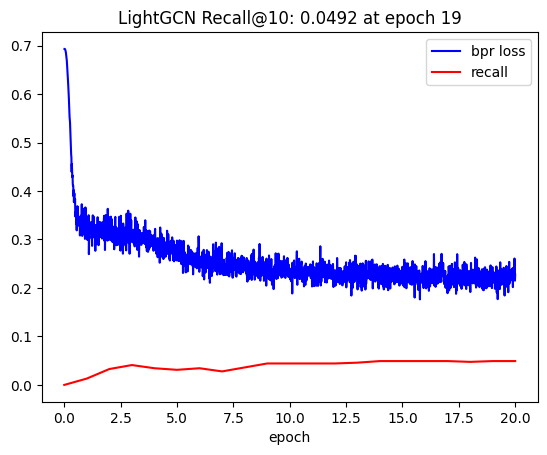

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='bpr loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.xlabel("epoch")
plt.legend()
plt.title(f'LightGCN Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}')
plt.show()

In [13]:
recall_list

[0.0,
 0.013114754098360656,
 0.03278688524590164,
 0.040983606557377046,
 0.03442622950819672,
 0.03114754098360656,
 0.03442622950819672,
 0.027868852459016394,
 0.036065573770491806,
 0.04426229508196721,
 0.04426229508196721,
 0.04426229508196721,
 0.04426229508196721,
 0.04590163934426229,
 0.04918032786885246,
 0.04918032786885246,
 0.04918032786885246,
 0.04918032786885246,
 0.047540983606557376,
 0.04918032786885246,
 0.04918032786885246]

In [14]:
max(recall_list)

0.04918032786885246